--- GC=F データ取得中 ---


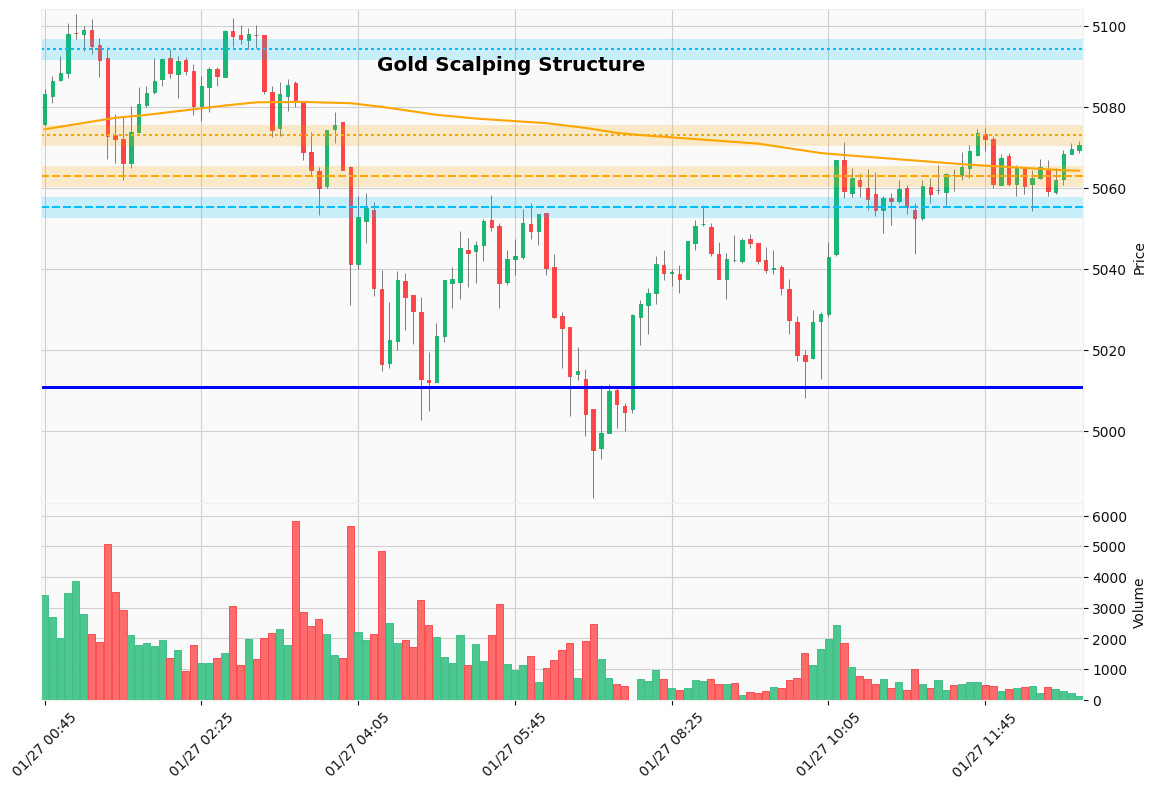

現在価格: 5070.60
昨日の高値: 5107.89990234375 / 安値: 5010.89990234375
直近レジスタンス(オレンジ): 5073.18
直近サポート(オレンジ): 5063.10


In [14]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import numpy as np
from datetime import timedelta
from scipy.signal import argrelextrema

class GoldChartGenerator:
    def __init__(self, symbol="GC=F"):
        self.symbol = symbol
        self.df = None
    
    def fetch_data(self, period="5d", interval="5m"):
        print(f"--- {self.symbol} データ取得中 ---")
        try:
            df = yf.download(self.symbol, interval=interval, period=period, progress=False)
            if df.empty: return None
            if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
            for col in ["Open", "High", "Low", "Close", "Volume"]:
                df[col] = pd.to_numeric(df[col], errors="coerce")
            df.dropna(inplace=True)
            if df.index.tz is None: df.index = df.index.tz_localize('UTC')
            df.index = df.index.tz_convert('Asia/Tokyo')
            df.index.name = "Datetime"
            df['MA200'] = df['Close'].rolling(window=200).mean()
            self.df = df
            return self.df
        except Exception: return None

    def _get_yesterday_levels(self):
        """昨日の高安取得"""
        if self.df is None: return None, None
        last_date = self.df.index[-1].date()
        prev_data = self.df[self.df.index.date < last_date]
        if prev_data.empty: return None, None
        target_date = prev_data.index[-1].date()
        target = prev_data[prev_data.index.date == target_date]
        return target['High'].max(), target['Low'].min()

    def _get_strong_levels(self, df, merge_dist=2.5, min_touches=3):
        """
        強いラインの中心価格を取得する
        """
        candidates = []
        for col, order in [('High', np.greater), ('Low', np.less)]:
            vals = df[col].values
            idxs = argrelextrema(vals, order, order=5)[0] 
            for idx in idxs:
                candidates.append(df.iloc[idx][col])
        
        candidates.sort()
        if not candidates: return []

        # クラスタリング
        clusters = []
        if candidates:
            current_cluster = [candidates[0]]
            for i in range(1, len(candidates)):
                if candidates[i] - current_cluster[-1] < merge_dist:
                    current_cluster.append(candidates[i])
                else:
                    clusters.append(current_cluster)
                    current_cluster = [candidates[i]]
            clusters.append(current_cluster)

        # 厳選（min_touches回以上反発した場所の中心のみ返す）
        strong_levels = []
        for cluster in clusters:
            if len(cluster) >= min_touches:
                strong_levels.append(np.mean(cluster))
        
        return strong_levels

    def generate_chart(self, display_hours=12, save_path=None):
        if self.df is None:
            print("データがありません")
            return
        
        # データ準備
        plot_start = self.df.index[-1] - timedelta(hours=display_hours)
        df_plot = self.df[self.df.index >= plot_start].copy()
        current_price = self.df['Close'].iloc[-1]
        
        # 昨日の高安
        y_high, y_low = self._get_yesterday_levels()
        
        # レベル取得
        levels = self._get_strong_levels(self.df, merge_dist=2.0, min_touches=3)
        
        # 現在価格上下で分類
        res_levels = [x for x in levels if x > current_price]
        sup_levels = [x for x in levels if x < current_price]
        
        res_levels.sort() # 近い順
        sup_levels.sort(reverse=True) # 近い順
        
        # --- 描画用リスト作成 ---
        h_lines = []
        h_colors = []
        h_styles = []
        h_widths = []
        h_alphas = []

        # 1. 昨日の高安（最強）: 赤・青の実線
        if y_high:
            h_lines.append(y_high); h_colors.append('red'); h_styles.append('-'); h_widths.append(2.0); h_alphas.append(1.0)
        if y_low:
            h_lines.append(y_low); h_colors.append('blue'); h_styles.append('-'); h_widths.append(2.0); h_alphas.append(1.0)

        # 2. 直近レジスタンス（オレンジ帯・点線）
        # 太さを極太(15〜20)にして透明度を下げることで「帯」に見せる安全策
        for i, level in enumerate(res_levels[:2]): # 2本まで
            color = 'orange' if i == 0 else 'deepskyblue' # 1本目はオレンジ、2本目は水色
            
            # 帯用（背景）
            h_lines.append(level)
            h_colors.append(color)
            h_styles.append('-') # 実線だが透明にする
            h_widths.append(15.0) # ★極太にして帯に見せる
            h_alphas.append(0.2)  # 薄くする

            # 線用（中心線）
            h_lines.append(level)
            h_colors.append(color)
            h_styles.append(':') # 点線
            h_widths.append(1.5)
            h_alphas.append(1.0)

        # 3. 直近サポート（オレンジ帯・破線）
        for i, level in enumerate(sup_levels[:2]): # 2本まで
            color = 'orange' if i == 0 else 'deepskyblue'
            
            # 帯用（背景）
            h_lines.append(level)
            h_colors.append(color)
            h_styles.append('-')
            h_widths.append(15.0) # ★極太
            h_alphas.append(0.2)

            # 線用（中心線）
            h_lines.append(level)
            h_colors.append(color)
            h_styles.append('--') # 破線
            h_widths.append(1.5)
            h_alphas.append(1.0)

        # --- プロット設定 ---
        ap = [mpf.make_addplot(self.df.loc[df_plot.index, 'MA200'], color='orange', width=1.5)]
        
        # 辞書設定（save_path対応）
        plot_args = {
            "type": "candle",
            "volume": True,
            "style": "yahoo",
            "title": "Gold Scalping Structure",
            "addplot": ap,
            "datetime_format": "%m/%d %H:%M", # ★日付フォーマット変更
            "figsize": (12, 8),
            "tight_layout": True,
            "hlines": dict(
                hlines=h_lines,
                colors=h_colors,
                linestyle=h_styles,
                linewidths=h_widths,
                alpha=h_alphas
            )
        }

        if save_path:
            plot_args["savefig"] = save_path

        # 描画実行
        mpf.plot(df_plot, **plot_args)

        # コンソール出力
        print(f"現在価格: {current_price:.2f}")
        print(f"昨日の高値: {y_high} / 安値: {y_low}")
        if res_levels: print(f"直近レジスタンス(オレンジ): {res_levels[0]:.2f}")
        if sup_levels: print(f"直近サポート(オレンジ): {sup_levels[0]:.2f}")

if __name__ == "__main__":
    gen = GoldChartGenerator()
    gen.fetch_data(period="5d", interval="5m")
    gen.generate_chart(display_hours=12)

--- GC=F データ取得中 ---


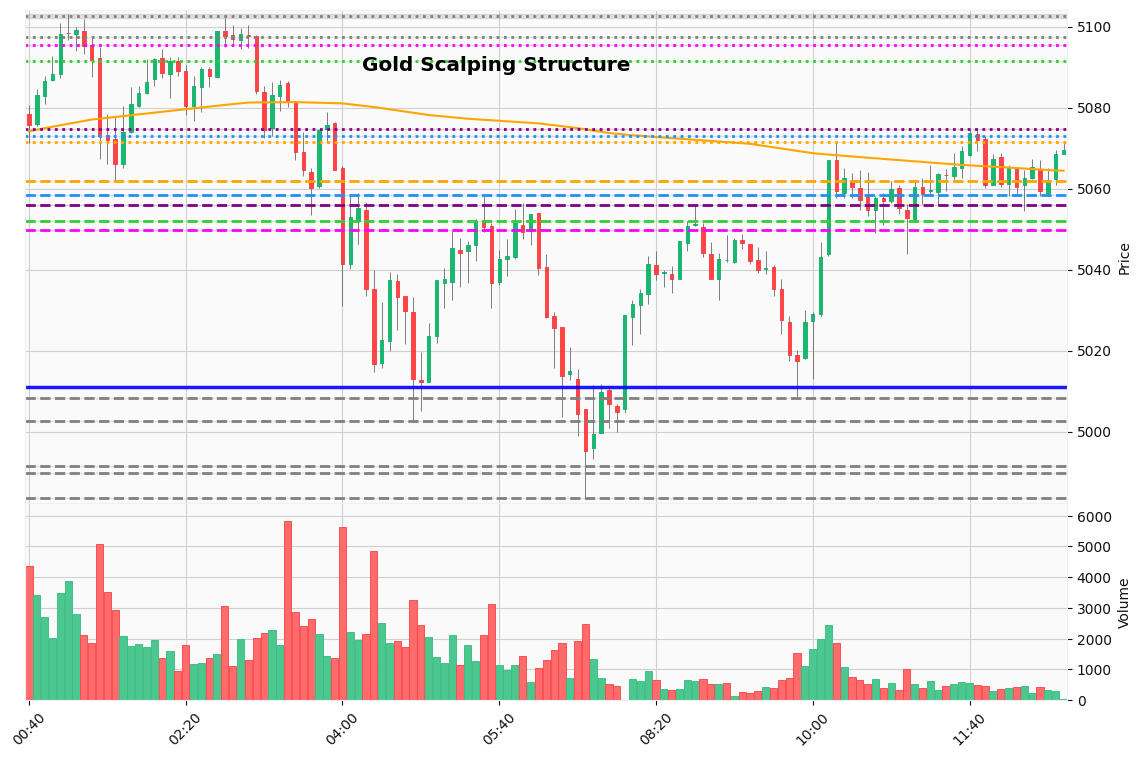

現在価格: 5069.60
昨日の高値(赤): 5107.89990234375 / 安値(青): 5010.89990234375


In [10]:
# --- 実行 ---
if __name__ == "__main__":
    gen = GoldChartGenerator()
    gen.fetch_data(period="5d", interval="5m")
    gen.generate_chart(display_hours=12)